## Preprocessing and clustering

In [1]:
# Core scverse libraries
import scanpy as sc
import anndata as ad
# Data retrieval
import pooch

In [2]:
sc.settings.set_figure_params(dpi=50, facecolor="white")

In [3]:
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
)
EXAMPLE_DATA.load_registry_from_doi()

In [4]:
samples = {
    "s1d1" : "s1d1_filtered_feature_bc_matrix.h5",
    "s1d3" : "s1d3_filtered_feature_bc_matrix.h5",
}

adatas = {}

for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata
    
adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())
adata

/home/user/miniconda3/envs/scanpy-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/miniconda3/envs/scanpy-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


sample
s1d1    8785
s1d3    8340
Name: count, dtype: int64


/home/user/miniconda3/envs/scanpy-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/miniconda3/envs/scanpy-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/miniconda3/envs/scanpy-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 17125 × 36601
    obs: 'sample'

The data contains app. 8,000 cells per sample and 36, 601 measured genes. Now we will investigate htese with a bascis processing and clustering workflow.

## Quality Control
`calculate_qc_metrics()` calculates common quality control (QC) metrics , which are laregely based on `calculateQCMetrics` 

In [5]:
# mitochondrial genes, "MT-", for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["mt"]

MIR1302-2HG    False
FAM138A        False
OR4F5          False
AL627309.1     False
AL627309.3     False
               ...  
AC141272.1     False
AC023491.2     False
AC007325.1     False
AC007325.4     False
AC007325.2     False
Name: mt, Length: 36601, dtype: bool

In [6]:
#ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith("RPS", "RPL")
adata.var["ribo"]

MIR1302-2HG    False
FAM138A        False
OR4F5          False
AL627309.1     False
AL627309.3     False
               ...  
AC141272.1     False
AC023491.2     False
AC007325.1     False
AC007325.4     False
AC007325.2     False
Name: ribo, Length: 36601, dtype: bool

In [7]:
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
adata.var["hb"]

MIR1302-2HG    False
FAM138A        False
OR4F5          False
AL627309.1     False
AL627309.3     False
               ...  
AC141272.1     False
AC023491.2     False
AC007325.1     False
AC007325.4     False
AC007325.2     False
Name: hb, Length: 36601, dtype: bool

In [8]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

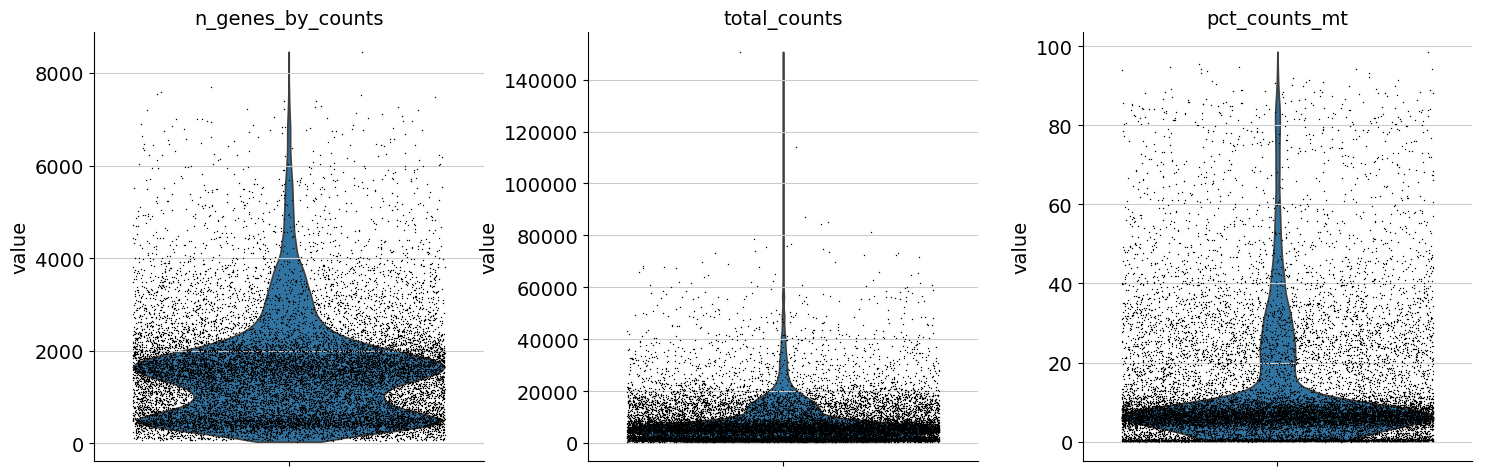

In [9]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True
)

Additonally, it is useful to consider QC metrics jointly by inspecting a scatter plot colored by `pct_counts_mt`.

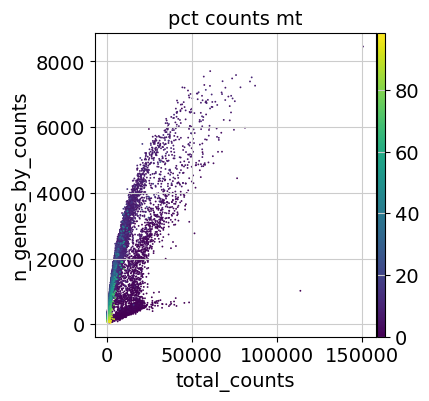

In [10]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

 Filter strategy can lead to lose of data  to focus on real biology.  here filters cells with less than 100 expressed gene which are detected 

In [11]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

## Doublet detection
Identify doublets detection is crucial as they can lead to missclassifications or distortions. Scanpy contains the doublet detection method, Scrublet which predicts cell dublets using a nearest-neighbor classifier of observed transcriptomes and simulated doublets.

In [12]:
pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


In [13]:
sc.pp.scrublet(adata, batch_key ="sample")

## Normalization
A common approach is count depth scaling with subsequent log plus one(log1p) transformation. 
Count depth normalizes the data to a "size factor" such as the median count depth in the dataset, ten thousand (CP10k) or one million (CPM, counts per million). The size factor for count depth scaling can be controlled via <target_sum> in <pp.normalize_total>. Here we applyig median count depth normalization with log1p transformation(AKA log1PF).

In [14]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [15]:
#  Normalize to median total counts
sc.pp.normalize_total(adata)
# Logarithmic the data
sc.pp.log1p(adata)

## Feature selection
The next step is to reduce the dimensionality of the datasets and only include the most informative genes.
This step is known as feature selection. The scanpy function <pp.highly_variable_genes> annotates highly variable genes by reproducing the implementation of Seruat, Cell ranger, and Seruat v3.

In [18]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")

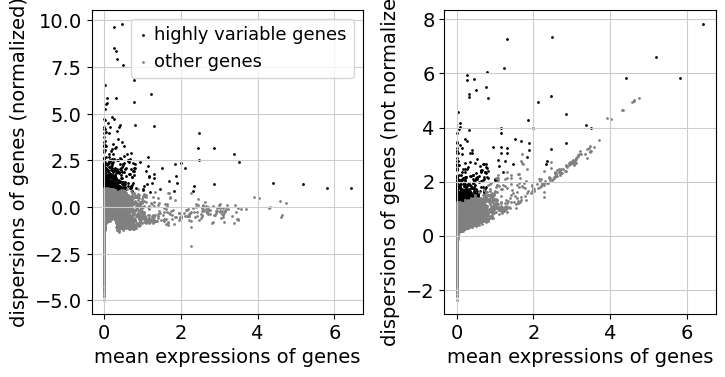

In [19]:
sc.pl.highly_variable_genes(adata)

## Dimensionality Reduction.
Principal component analysis(PCA) reveals the main axes of variation and denoises the data.


In [20]:
sc.tl.pca(adata)

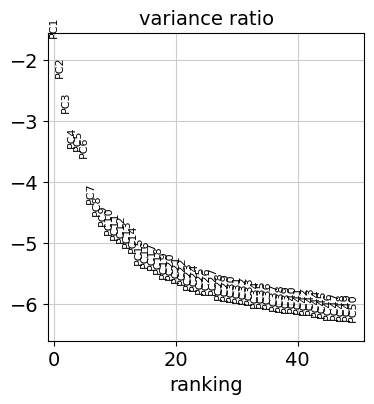

In [21]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

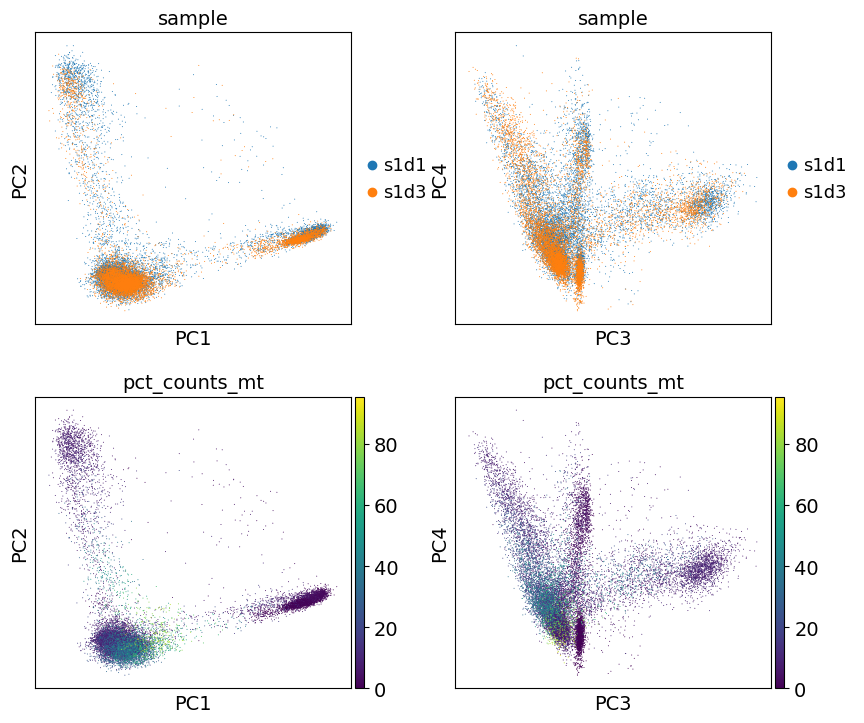

In [22]:
# Plot the data
sc.pl.pca(adata, color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"], 
         dimensions=[(0,1), (2,3), (0,1), (2,3)], ncols=2, size=2,)

## Nearesr neighbor graph construction and visualization
Compute the neighborhood graph of cells using the PCA representation of the data matrix.

In [23]:
sc.pp.neighbors(adata)

/home/user/miniconda3/envs/scanpy-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
sc.pp.neighbors(adata)

In [25]:
sc.tl.umap(adata)

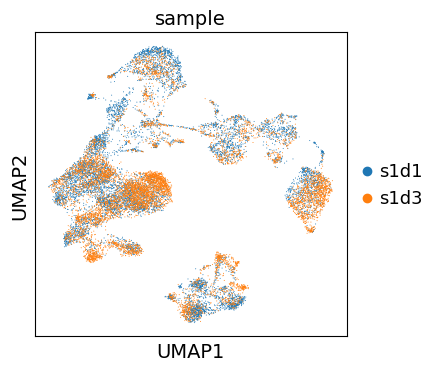

In [26]:
# Visualize
sc.pl.umap(adata, color="sample", size=2,)

## Clustering
Most recommended cluesteirng mehtod the Leiden graph-clustering method(community detectionbn based on optimizing modularity). Leiden clusterting method directly clusters the neighborhood graph of cells, which already computed in the previous section.

In [27]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster.
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

TypeError: community_leiden() got an unexpected keyword argument 'resolution'

In [28]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

TypeError: community_leiden() got an unexpected keyword argument 'resolution'

In [29]:
sc.tl.leiden(adata, resolution=1.0) 

/tmp/ipykernel_60578/3154749211.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1.0)


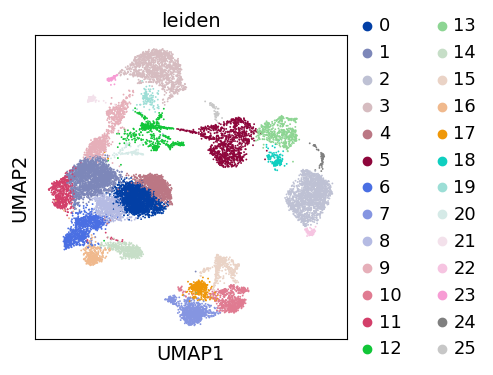

In [30]:
sc.pl.umap(adata, color=["leiden"])

## Re-assess quality control and cell filtering
As indicated before,we will now re-assess our filtering strategy by visualizing different QC metrics using UMAP.


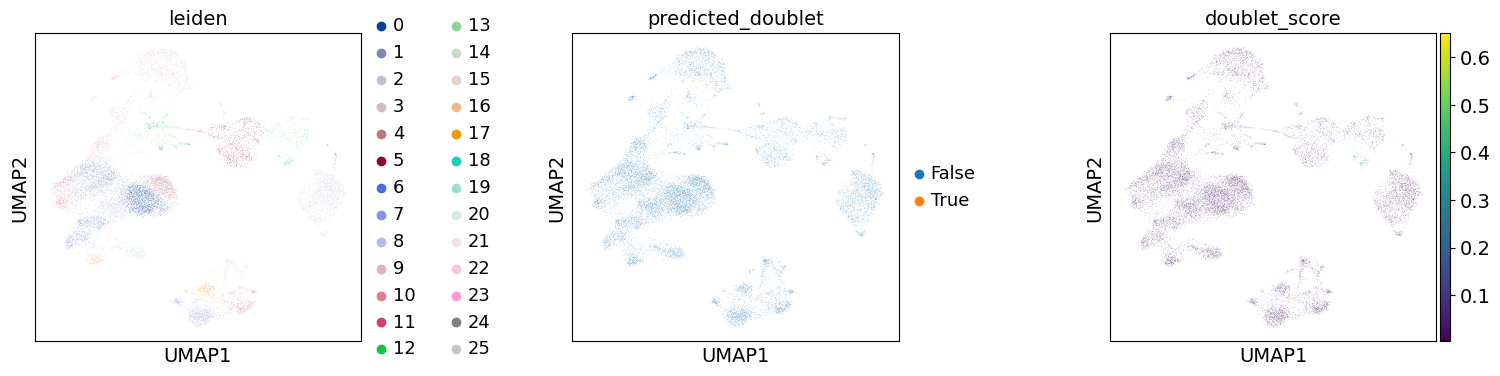

In [31]:
sc.pl.umap(adata, color=["leiden", "predicted_doublet", "doublet_score"],
          #increaed horizontal panel between panels
          wspace=0.5, size=0.3,)